<a href="https://colab.research.google.com/github/blue-romeo/eda-on-football-movies/blob/main/flower_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preface

This project involves fine-tuning a pre-trained ResNet-18 model on the CIFAR-10 dataset to classify images of flowers into five classes: roses, dandelion, tulips, sunflowers, and daisy. The fine-tuned model can then be used to predict the class of a given flower image.

# PART 1: FINE-TUNING THE MODEL

## Importing libraries

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import timm
import torch.optim as optim
import requests
from io import BytesIO

## Loading data

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Specify the path to your data directory on Google Drive
data_dir = '/content/drive/MyDrive/flower_photos'
# Initialize lists to store image paths and labels
image_path_list = []
label_list = []

# Iterate through class categories in the "data" directory
for class_cat in os.listdir(data_dir):
    # Iterate through image files within each class category
    for image_object in os.listdir(os.path.join(data_dir, class_cat)):
        # Append image path to the list
        image_path_list.append(os.path.join(data_dir, class_cat, image_object))
        # Append class category as the label to the list
        label_list.append(f"{class_cat}")

# Create a Pandas DataFrame from the lists
df = pd.DataFrame()
df["image_path"] = image_path_list
df["label"] = label_list

# Display the DataFrame
print(df)

Mounted at /content/drive
                                             image_path       label
0     /content/drive/MyDrive/flower_photos/daisy/104...       daisy
1     /content/drive/MyDrive/flower_photos/daisy/105...       daisy
2     /content/drive/MyDrive/flower_photos/daisy/101...       daisy
3     /content/drive/MyDrive/flower_photos/daisy/101...       daisy
4     /content/drive/MyDrive/flower_photos/daisy/103...       daisy
...                                                 ...         ...
3665  /content/drive/MyDrive/flower_photos/sunflower...  sunflowers
3666  /content/drive/MyDrive/flower_photos/sunflower...  sunflowers
3667  /content/drive/MyDrive/flower_photos/sunflower...  sunflowers
3668  /content/drive/MyDrive/flower_photos/sunflower...  sunflowers
3669  /content/drive/MyDrive/flower_photos/sunflower...  sunflowers

[3670 rows x 2 columns]


In essence, this code walks through the flower photos folder structure on Google Drive, identifies each image, and stores its path and label in respective lists for later use in the machine learning pipeline.

## Visualizing the images

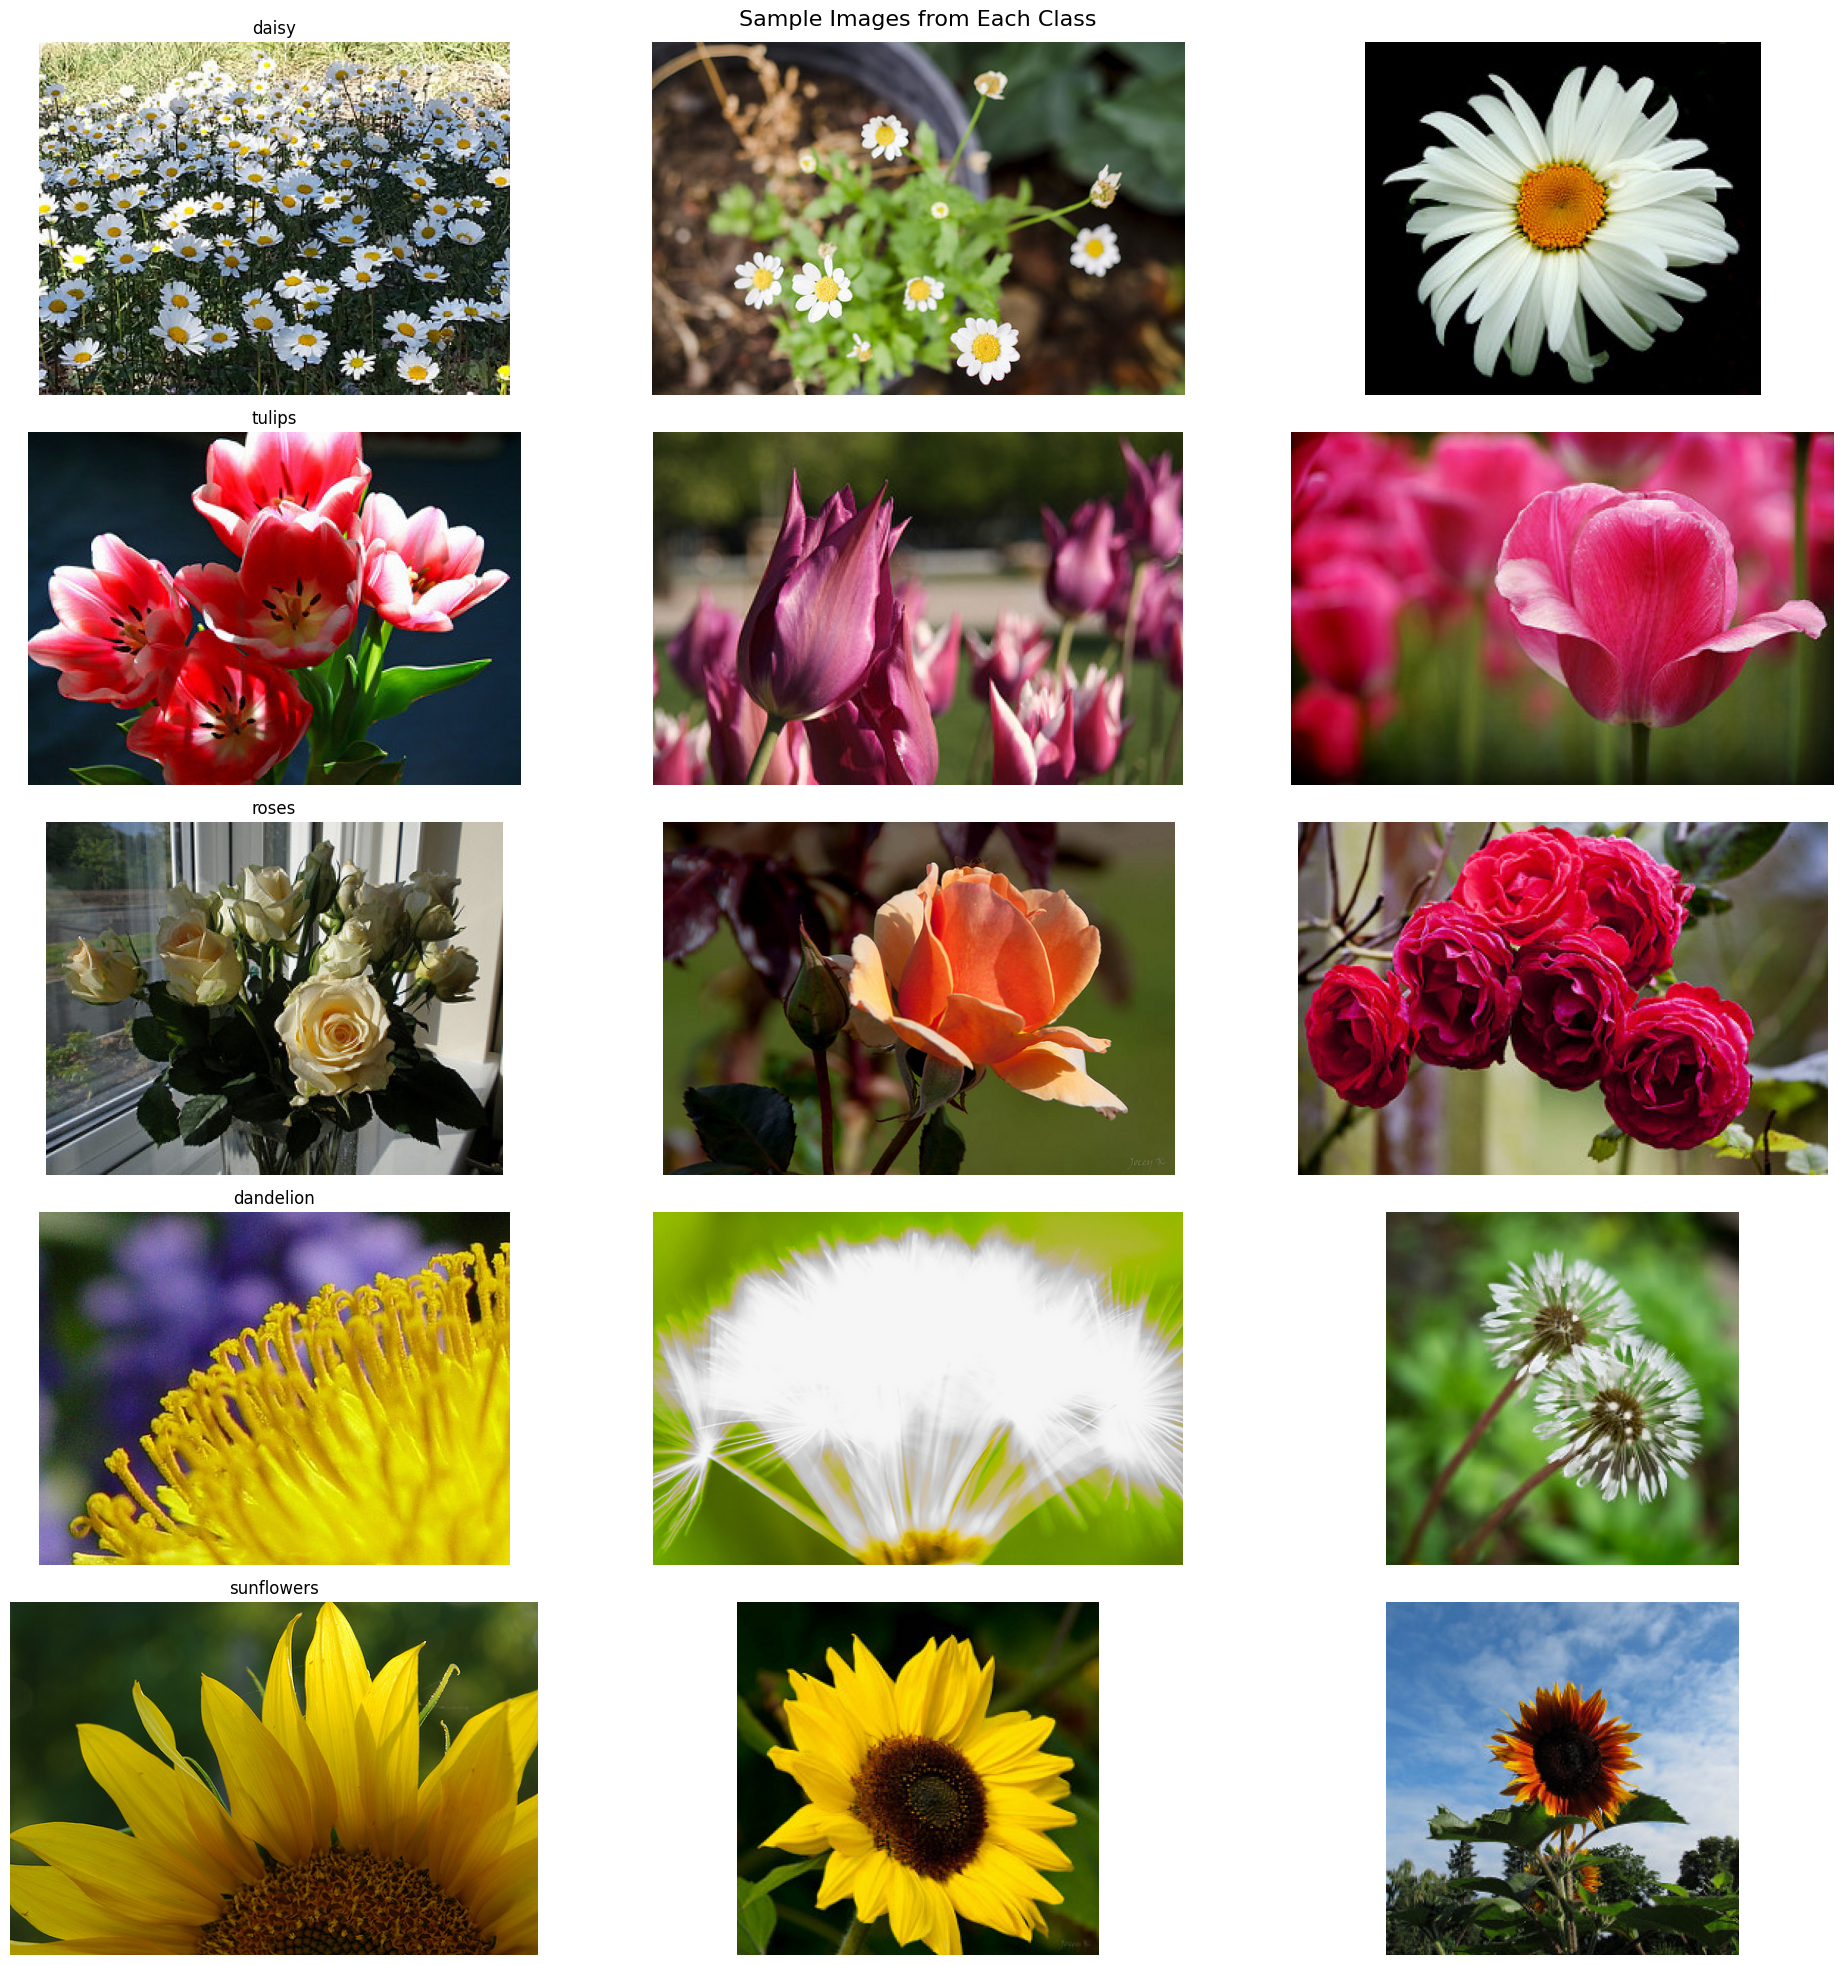

In [ ]:
# Get unique classes
classes = df['label'].unique()

# Number of images to display per class
n_images = 3

# Set up the plot
fig, axes = plt.subplots(len(classes), n_images, figsize=(20, 4*len(classes)))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for i, class_name in enumerate(classes):
    # Filter dataframe for current class
    class_df = df[df['label'] == class_name]

    # Randomly sample n_images from this class
    sample_images = class_df['image_path'].sample(n_images).tolist()

    for j, img_path in enumerate(sample_images):
        # Open and display the image
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

        # Set the title for the first image in each row
        if j == 0:
            axes[i, j].set_title(f'{class_name}', fontsize=12)

plt.tight_layout()
plt.show()


## Splitting the data into testing and training sets

In [ ]:
# Define the split ratio
test_ratio = 0.20 # 20% of data will go to test

# split the data
train_df, test_df = train_test_split(df, test_size=test_ratio, stratify=df['label'], random_state=42)

print(f"Original dataset shape: {df.shape}")
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")


# Print class distribution
print("\nClass distribution:")
print("Original:")
print(df['label'].value_counts(normalize=True))
print("\nTrain:")
print(train_df['label'].value_counts(normalize=True))
print("\nTest:")
print(test_df['label'].value_counts(normalize=True))

Original dataset shape: (3670, 2)
Train dataset shape: (2936, 2)
Test dataset shape: (734, 2)

Class distribution:
Original:
label
dandelion     0.244687
tulips        0.217711
sunflowers    0.190463
roses         0.174659
daisy         0.172480
Name: proportion, dtype: float64

Train:
label
dandelion     0.244891
tulips        0.217643
sunflowers    0.190395
roses         0.174728
daisy         0.172343
Name: proportion, dtype: float64

Test:
label
dandelion     0.243869
tulips        0.217984
sunflowers    0.190736
roses         0.174387
daisy         0.173025
Name: proportion, dtype: float64


## Define image transforms (Augmenter)

In [ ]:
IMAGE_SIZE = 124

# this will be used during training, this will hold all the augmentation/transformation configs
training_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                             transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# this will be used during testing / infernece, wo don't want any kind of additional transformation applied at the time of running model prediction in test / production inviroment
test_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                             transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


## Custom Pytorch Dataset

In [ ]:
# Define custom Dataset -> this will help you load images from your csv file
class CustomTrainingData(Dataset):
    def __init__(self, csv_df, class_list, transform=None):
        self.df = csv_df
        self.transform = transform
        self.class_list = class_list

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        image = Image.open(self.df.iloc[index].image_path).convert('RGB')
        label = self.class_list.index(self.df.iloc[index].label)

        if self.transform:
            image = self.transform(image)

        return image, label

# list of classes in your dataset
CLASS_LIST = ['tulips', 'roses', 'sunflowers', 'daisy','dandelion']

# create data object
train_data_object = CustomTrainingData(train_df, CLASS_LIST, training_transform)
test_data_object = CustomTrainingData(test_df, CLASS_LIST, test_transform)

In essence, this code creates a structured way to load your flower images and labels from a CSV file, apply any necessary transformations, and make them readily accessible for training and evaluating your machine learning model.

## The data loaders

In [ ]:
BATCH_SIZE = 32

# now define dataloader, this will load the images batches from CustomTrainingData object
train_loader = DataLoader(train_data_object, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data_object, batch_size=BATCH_SIZE, shuffle=False)

## The model

In [ ]:
# Define the model
model = timm.create_model('resnet18', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

The last fully connected layers of the resnet18 will be replaced with 5 new ones that are specifically tailored to our flower classes.

### The loss function

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In essence, these two lines ensure that your model runs on the most efficient hardware available, utilizing the GPU for faster training if possible, and defaulting to the CPU otherwise.

## Training

In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/30, Loss: 1.1475, Accuracy: 0.6144
Epoch 2/30, Loss: 0.9712, Accuracy: 0.6975
Epoch 3/30, Loss: 0.8383, Accuracy: 0.7534
Epoch 4/30, Loss: 0.5843, Accuracy: 0.7902
Epoch 5/30, Loss: 0.8140, Accuracy: 0.8120
Epoch 6/30, Loss: 0.6722, Accuracy: 0.8215
Epoch 7/30, Loss: 0.6842, Accuracy: 0.8324
Epoch 8/30, Loss: 0.5229, Accuracy: 0.8433
Epoch 9/30, Loss: 0.5911, Accuracy: 0.8488
Epoch 10/30, Loss: 0.6397, Accuracy: 0.8433
Epoch 11/30, Loss: 0.6871, Accuracy: 0.8597
Epoch 12/30, Loss: 0.4469, Accuracy: 0.8488
Epoch 13/30, Loss: 0.3685, Accuracy: 0.8665
Epoch 14/30, Loss: 0.7032, Accuracy: 0.8665
Epoch 15/30, Loss: 0.4724, Accuracy: 0.8747
Epoch 16/30, Loss: 0.4350, Accuracy: 0.8706
Epoch 17/30, Loss: 0.2467, Accuracy: 0.8719
Epoch 18/30, Loss: 0.4077, Accuracy: 0.8719
Epoch 19/30, Loss: 0.7090, Accuracy: 0.8747
Epoch 20/30, Loss: 0.2942, Accuracy: 0.8801
Epoch 21/30, Loss: 0.1409, Accuracy: 0.8719
Epoch 22/30, Loss: 0.3082, Accuracy: 0.8719
Epoch 23/30, Loss: 0.5690, Accuracy: 0.87

### Saving the training weights

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'resnet18_flowers.pth')

# PART 2: MAKING PREDICTIONS


## Loading the model

In [ ]:
# Load the trained model
model = timm.create_model('resnet18')
model.fc = nn.Linear(model.fc.in_features, 5)
model.load_state_dict(torch.load('resnet18_flowers.pth'))
model.eval()


<ipython-input-36-6a39884ca2d3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_flowers.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

## File upload

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sun.jpg to sun.jpg


## Transforming the image

In [ ]:
image_path = '/content/sun.jpg'  # Path to the image
try:
  image = Image.open(image_path)
  # Define image_transform
  image_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  # Continue with processing the image
  input_image = image_transform(image).unsqueeze(0)
except FileNotFoundError:
  print(f"Error: The file '{image_path}' was not found.")

## The prediction

Predicted class: 2 - sunflowers


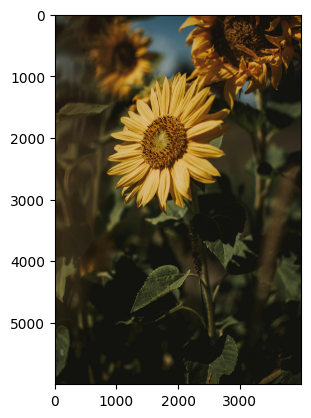

In [ ]:
# Make prediction
import matplotlib.pyplot as plt
class_names = ['tulips', 'roses', 'sunflowers', 'daisy','dandelion']

plt.imshow(image)
with torch.no_grad():
    model_output = model(input_image)
    _, predicted_class = torch.max(model_output, 1)

predicted_class_index = predicted_class.item()
predicted_class_name = class_names[predicted_class_index]

print(f'Predicted class: {predicted_class_index} - {predicted_class_name}')